In [64]:
from IPython.display import clear_output, display

In [5]:
!pip install lovely-tensors gpustat
clear_output()

In [6]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import lovely_tensors as lt
lt.monkey_patch()

In [7]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

fashion_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

clear_output()

In [8]:
class StackedDataset(Dataset):
    def __init__(self, mnist_dataset, fashion_mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.fashion_mnist_dataset = fashion_mnist_dataset

    def __len__(self):
        return min(len(self.mnist_dataset), len(self.fashion_mnist_dataset)//2)

    def __getitem__(self, idx):
        mnist_img, mnist_label = self.mnist_dataset[idx]
        fashion_img_left, fashion_label_left = self.fashion_mnist_dataset[2*idx]

        fashion_img_right, fashion_label_right = self.fashion_mnist_dataset[2*idx + 1]

        stacked_img = torch.cat([fashion_img_left, mnist_img, fashion_img_right], dim=2)

        label = fashion_label_left if mnist_label % 2 == 0 else fashion_label_right

        return stacked_img, label

stacked_trainset = StackedDataset(mnist_trainset, fashion_trainset)
stacked_testset = StackedDataset(mnist_testset, fashion_testset)

In [9]:

class CustomNet(nn.Module):
    def __init__(self, num_classes, in_channels=1):
        super(CustomNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(1024, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
batch_size = 128

trainloader = DataLoader(stacked_trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(stacked_testset, batch_size=batch_size, shuffle=False)

net = CustomNet(num_classes=10).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.002)

epochs = 100

In [11]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    running_loss = 0.0
    correct = 0
    total = 0
    net.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print(f" train loss: {running_loss / len(trainloader):.5f}, "
          f" train acc: {100 * correct / len(stacked_trainset):.2f}%", end=", ")

    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        net.eval()
        for data in testloader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            correct += (predicted == labels).sum().item()

    print(f" test loss: {running_loss / len(testloader):.5f}, "
          f" test acc: {100 * correct / len(stacked_testset):.2f}%")

print("Training finished")
net.eval()

Epoch 1
 train loss: 1.51947,  train acc: 43.22%,  test loss: 0.97800,  test acc: 64.70%
Epoch 2
 train loss: 0.83731,  train acc: 69.62%,  test loss: 0.68951,  test acc: 74.58%
Epoch 3
 train loss: 0.68470,  train acc: 75.17%,  test loss: 0.62177,  test acc: 77.40%
Epoch 4
 train loss: 0.60451,  train acc: 78.09%,  test loss: 0.57097,  test acc: 79.50%
Epoch 5
 train loss: 0.55030,  train acc: 80.24%,  test loss: 0.53455,  test acc: 81.30%
Epoch 6
 train loss: 0.51261,  train acc: 81.84%,  test loss: 0.50338,  test acc: 81.90%
Epoch 7
 train loss: 0.47404,  train acc: 83.11%,  test loss: 0.51168,  test acc: 81.72%
Epoch 8
 train loss: 0.45258,  train acc: 83.96%,  test loss: 0.47369,  test acc: 83.14%
Epoch 9
 train loss: 0.42746,  train acc: 84.74%,  test loss: 0.48798,  test acc: 82.56%
Epoch 10
 train loss: 0.40947,  train acc: 85.35%,  test loss: 0.46427,  test acc: 83.48%
Epoch 11
 train loss: 0.39064,  train acc: 86.39%,  test loss: 0.48054,  test acc: 83.90%
Epoch 12
 train los

KeyboardInterrupt: 

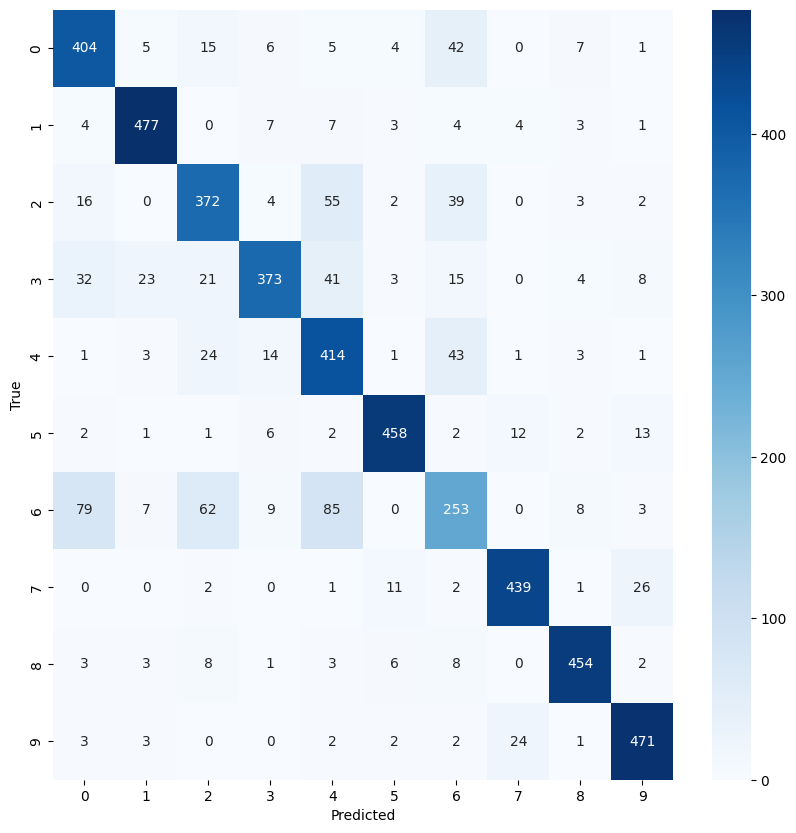

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        predicted = outputs.argmax(dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [92]:
def plot_example(im, pred, label):
    print("Wrong pred example.")
    im = TF.resize((images[0] + 1)/2, [200])
    im = TF.to_pil_image(im)
    display(im)

    probabilities = F.softmax(outputs, 1).squeeze().tolist()
    plt.bar(range(len(probabilities)), probabilities)
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Class Probabilities')
    plt.show()

Right pred example.
Wrong pred example.


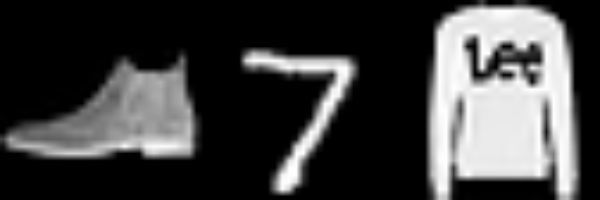

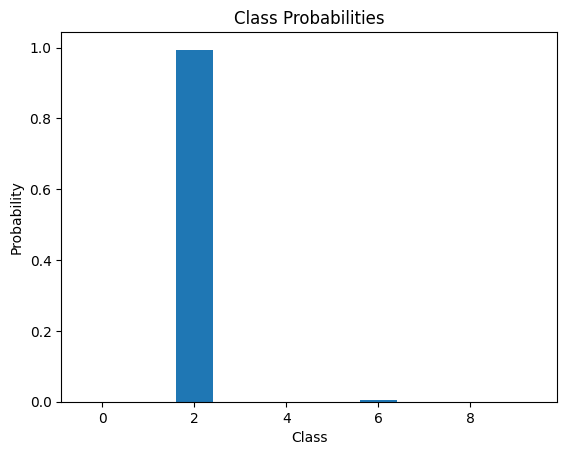

Wrong pred example.


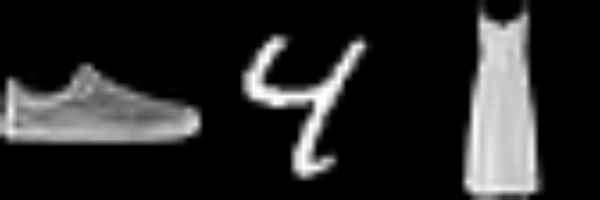

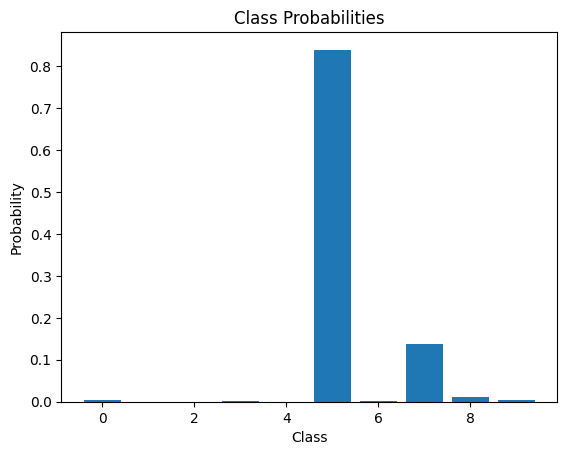

In [93]:
net.eval()

wrong = False
right = False

with torch.no_grad():
    for images, labels in DataLoader(stacked_testset, batch_size=1):
        if wrong and right:
            break
        images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        predicted = outputs.argmax(dim=1)
        if predicted != labels and not wrong:
            plot_example(im, outputs, labels)
            wrong=True
        
        if predicted == labels and not right:
            print("Right pred example.")
            plot_example(im, outputs, labels)
            right=True

